### Временные ряды

План семинара:

1. [Предобработка временного ряда](#preprocess)
2. [Генерация признаков](#features)
3. [Кросс-валидация для временных рядов](#cv)
4. [Подбор гиперпараметров: Optuna](#optuna)
5. [Библиотеки для временных рядов](#prophet)

In [168]:
%%capture
!pip install catboost -q

In [169]:
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5
#init_notebook_mode(connected=True)

### Предобработка временного ряда  <a name="preprocess">

> **Временной ряд** – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки. <

Таким образом, данные оказываются упорядочены относительно моментов времени, и, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь.

Возьмем датасет, в котором будет присутвовать переменная, изменяющая во времени. Давайте сегодян попробуем поработать с набором данных по среднесуточной дневной температуре в городе Дели, собранном за несколько лет. Подробнее почитать про датасет можно на [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

Датасет сразу разбит на две части - train и test, но будем использовать для обучения и валидации моделей только train, оставив test как отложенную выборку для проверки качества.

In [174]:
df = pd.read_csv('./DailyDelhiClimateTrain.csv')

print(f"Дни с {min(df.date)} по {max(df.date)}, всего {df.date.nunique()} дней.")
df.head()

Дни с 2013-01-01 по 2016-12-31, всего 1461 дней.


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [175]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

Нам понадобится колонка с датами, но сперва нужно ее преобразовать из строки в timestamp.

In [177]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

Сразу полезно построить какой-нибудь простой линейный график, чтобы посмотреть на поведение выбранной переменной. У нас их несколько в датасете - влажность, средняя температура, скорость ветра, среднее атмосферное давленеи.

Давайте выберем среднюю температуру и обозначим за целевую переменную, которую нам нужно предскзаать.

Text(0, 0.5, 'Mean temperature')

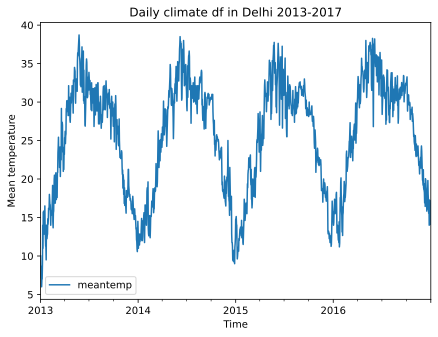

In [179]:
ax = df[['meantemp','date']].groupby('date').mean().plot(title='Daily climate df in Delhi 2013-2017')
ax.set_xlabel("Time")
ax.set_ylabel("Mean temperature")

Text(0, 0.5, 'meanpressure')

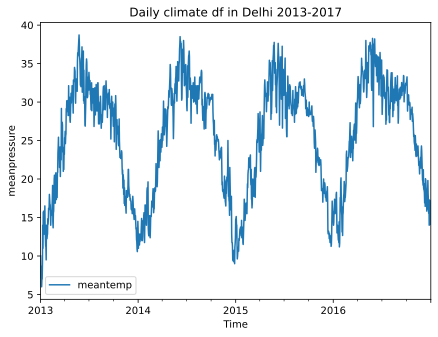

In [180]:
ax = df[['meantemp','date']].groupby('date').mean().plot(title='Daily climate df in Delhi 2013-2017')
ax.set_xlabel("Time")
ax.set_ylabel("meanpressure")

In [181]:
df = df[['date','meantemp']].set_index('date')

Предсказание температуры - отличный пример того, когда ряд точно содержит сезонность. Как уже упоминалось на лекции, временной ряд можно декомпозировать на 3 компонентны:

* **Тренд** - плавное долгосрочное изменение уровня ряда
* **Цикличность** - изменения уровня ряда с переменным периодом
* **Сезонность** - циклические изменения уровня ряда с постоянным периодом
* **Шум** - непрогнозируемая случайная компонента ряда

Быстро получить разложние можно, например, с помощью библиотеки statsmodels. Давайте разложим наш ряд:

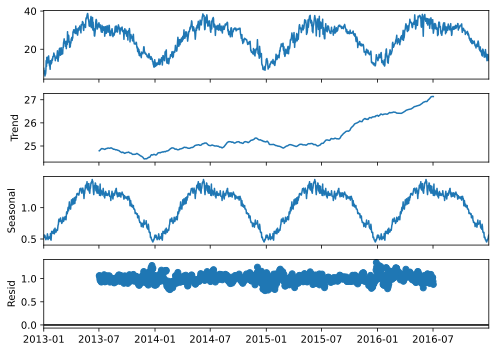

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df,
                            model='multiplicative',
                            period=365)
result.plot();

Наша постановка задачи на этих данных - спрогнозировать, какая будет температура в следующий день и, желательно, несколько дней.

### Скользящее среднее

Начнем моделирование с простого предположения - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

Например, можно построить прогноз за последние 10 дней:

In [188]:
df[-10:]

,meantemp
date,
2016-12-22,17.285714
2016-12-23,15.550000
2016-12-24,17.318182
2016-12-25,14.000000
2016-12-26,17.142857
2016-12-27,16.850000
2016-12-28,17.217391
2016-12-29,15.238095
2016-12-30,14.095238


In [189]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df, 10)

15.975010946338179

In [190]:
def plot_moving_average(df, n, plot_bounds=False):

    """
    df - dataframe with time series
    n - rolling window size
    plot_bounds: bool - to draw a confidence interval
    """

    rolling_mean = df.rolling(window=n).mean()

    fig, ax = plt.subplots(figsize=(12, 3))
    plt.title(f"Moving average\n window size = {n}")
    plt.plot(rolling_mean, "blue", label="Rolling mean trend")

    # Доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std = df.rolling(window=n).std()
        upper_bound = rolling_mean + 1.96 * rolling_std
        lower_bound = rolling_mean - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(df[n:], "grey", label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13)))
    plt.xticks(rotation=45)

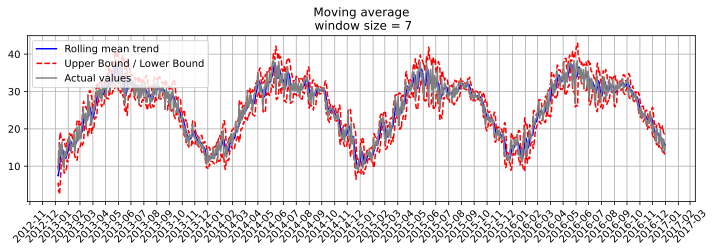

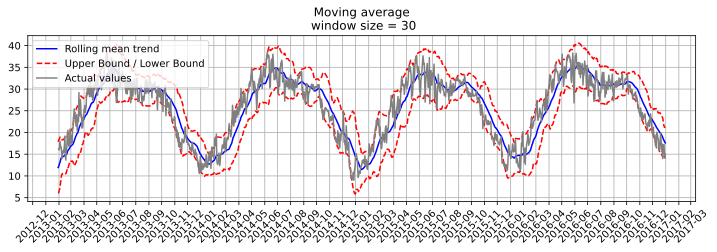

In [191]:
plot_moving_average(df, 7, plot_bounds=True)  # сглаживаем по неделям
plot_moving_average(df, 30, plot_bounds=True)  # сглаживаем по месяцам

### Взвешенное среднее

Модификацией скользящего среднего является взвешенное среднее, внутри которого наблюдениям придаются различные веса, в суме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [194]:
def weighted_average(df, weights):
    """
        Calculate weighted average on the df.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += df.iloc[-n - 1] * weights[n]
    return float(result)

weighted_average(df, [0.6, 0.2, 0.1, 0.07, 0.03])

15.085153481529911

### Экспоненциальное сглаживание

Посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд.

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [197]:
def exponential_smoothing(df, alpha):
    result = [df[0]]  # first value stays the same as in initial data
    for n in range(1, len(df)):
        result.append(alpha * df[n] + (1 - alpha) * result[n - 1])
    return result

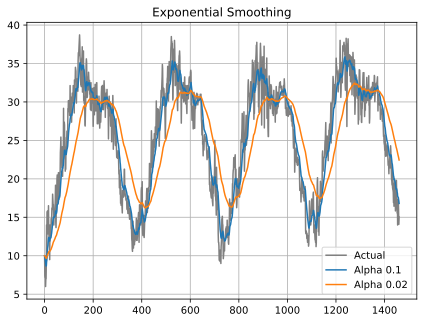

In [198]:
plt.figure(figsize=(7, 5))
plt.plot(df.meantemp.values, "grey", label="Actual")
for alpha in [0.1, 0.02]:
    plt.plot(exponential_smoothing(df.meantemp, alpha), label=f"Alpha {alpha}")
plt.legend(loc="best")
plt.axis("tight")
plt.title("Exponential Smoothing")
plt.grid(True)

### Двойное экспоненциальное сглаживание

До этого мы могли получить в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

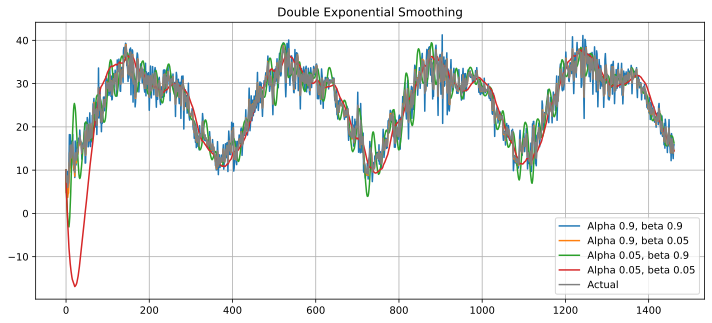

In [201]:
def double_exponential_smoothing(df, alpha, beta):
    result = [df[0]]
    for n in range(1, len(df) + 1):
        if n == 1:
            level, trend = df[0], df[1] - df[0]
        if n >= len(df):  # прогноз
            value = result[-1]
        else:
            value = df[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result



plt.figure(figsize=(12, 5))
for alpha in [0.9, 0.05]:
    for beta in [0.9, 0.05]:
        plt.plot(
                double_exponential_smoothing(df.meantemp, alpha, beta),
                label=f"Alpha {alpha}, beta {beta}",
            )
plt.plot(df.meantemp.values, 'grey', label="Actual")
plt.legend(loc="best")
plt.axis("tight")
plt.title("Double Exponential Smoothing")
plt.grid(True)

Можно пойти дальше - в тройное экспоненциальное сглажтивание :) Это называется модель [Хольта-Винтерса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%A5%D0%BE%D0%BB%D1%8C%D1%82%D0%B0-%D0%A3%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D1%81%D0%B0).

Или вспомнить весь арсенал эконометрических методов и моделей: например, ARMA, ARIMA, SARIMA и др. В этот раз мы эти модели опустим, но сделаем лирическое отступление про их полезность, но на практике - сложность настройки и большие затраты по времени на подбор весов.

На практике можно использовать и известные нам методы машинного обучения - например, линейную регрессию или градиентный бустинг.

### Генерация признаков <a name="features">

Однако, для моделей нам нужны классные фичи. Давайте попробуем посмотреть, что мы можем сделать, если у нас известны только даты и целевая переменная.

Напишем функцию, которая возвращает словарь, где ключами являются уникальные категории признака cat_feature, а значениями - средние по real_feature.

In [205]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Давай достанем из дат отдельно день недели, номер недели, номер месяца и год, и добавим их как новые признаки.

In [207]:
data = df.copy()

data["weekday"] = data.index.weekday
data["week"] = df.index.to_series().dt.isocalendar().week
data["month"] = data.index.month
data["year"] = data.index.year
data.head()

,meantemp,weekday,week,month,year
date,,,,,
2013-01-01,10.000000,1,1,1,2013
2013-01-02,7.400000,2,1,1,2013
2013-01-03,7.166667,3,1,1,2013
2013-01-04,8.666667,4,1,1,2013
2013-01-05,6.000000,5,1,1,2013


Среднее значение целевой переменной по месяцам:

In [209]:
code_mean(data, "month", "meantemp")

{1: 13.3386232718894,
 2: 17.620422166329245,
 3: 22.914103302611366,
 4: 29.376614392551893,
 5: 33.31588918526867,
 6: 33.734010607448106,
 7: 30.995781565314296,
 8: 30.601776852904106,
 9: 30.433215874175826,
 10: 27.11315430900459,
 11: 20.656854544822895,
 12: 15.666317026303092}

Можно это удобно обернуть в функцию и заменить исходные признаки на их среднее как один из вариантов препроцессинга, а также - добавить значения целевой переменной с разной длинной временного лага.

In [211]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.meantemp.shift(i)

    data["weekday"] = data.index.weekday
    data["week"] = data.index.to_series().dt.isocalendar().week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["weekday_average"] = list(map(code_mean(data[:test_index], "weekday", "meantemp").get, data.weekday))
    data["week_average"] = list(map(code_mean(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "meantemp").get, data.year))

    # выкидываем закодированные средними признаки
    data.drop(["weekday", "week", 'month', 'year'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

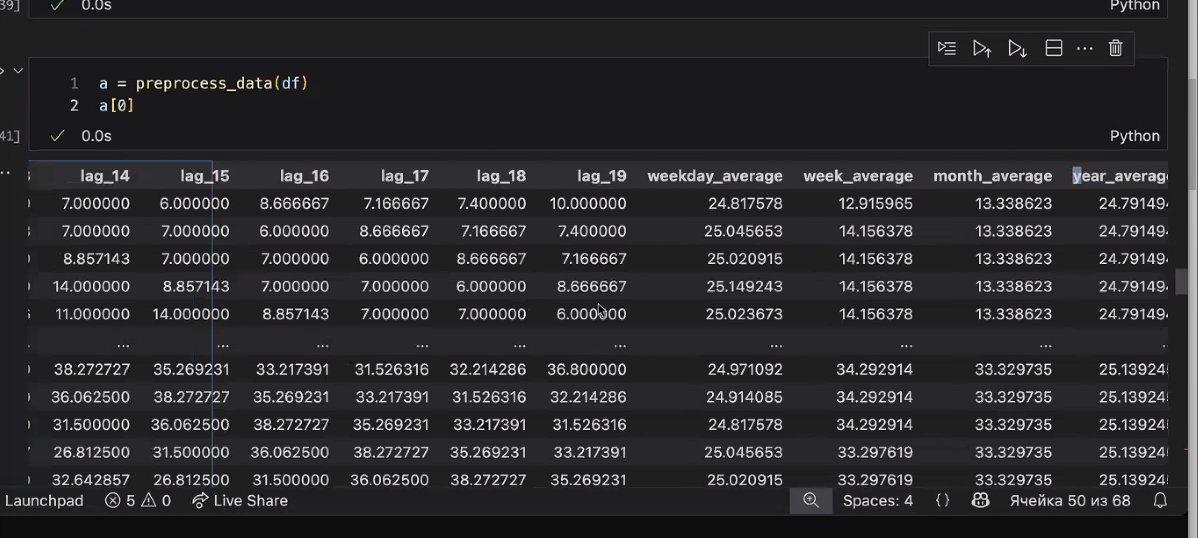

In [219]:
a = preprocess_data(df)
a [0]


,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,weekday_average,week_average,month_average,year_average
0,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,24.817578,12.915965,13.338623,24.791494
1,13.833333,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,25.045653,14.156378,13.338623,24.791494
2,16.500000,13.833333,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,25.020915,14.156378,13.338623,24.791494
3,13.833333,16.500000,13.833333,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,25.149243,14.156378,13.338623,24.791494
4,12.500000,13.833333,16.500000,13.833333,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,25.023673,14.156378,13.338623,24.791494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,36.166667,38.200000,37.562500,37.562500,36.000000,32.642857,26.812500,31.500000,36.062500,38.272727,35.269231,33.217391,31.526316,32.214286,36.800000,24.971092,34.292914,33.329735,25.139245
1238,35.428571,36.166667,38.200000,37.562500,37.562500,36.000000,32.642857,26.812500,31.500000,36.062500,38.272727,35.269231,33.217391,31.526316,32.214286,24.914085,34.292914,33.329735,25.139245
1239,34.625000,35.428571,36.166667,38.200000,37.562500,37.562500,36.000000,32.642857,26.812500,31.500000,36.062500,38.272727,35.269231,33.217391,31.526316,24.817578,34.292914,33.329735,25.139245
1240,36.071429,34.625000,35.428571,36.166667,38.200000,37.562500,37.562500,36.000000,32.642857,26.812500,31.500000,36.062500,38.272727,35.269231,33.217391,25.045653,33.297619,33.329735,25.139245


### Кросс-валидация для временных рядов <a name="cv">

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

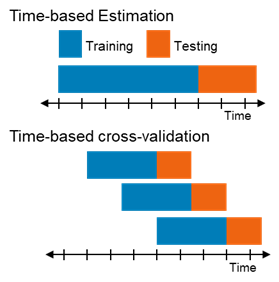

Обучим линейную регрессию:

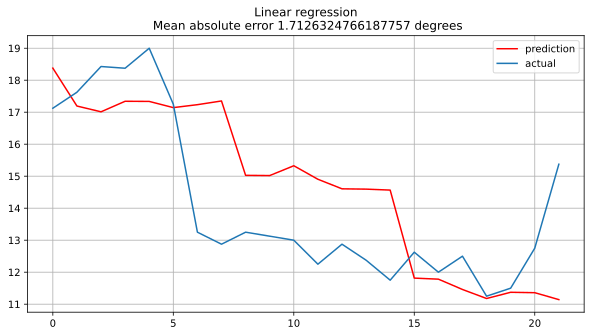

In [280]:
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = preprocess_data(df, test_size=0.3, lag_start=12, lag_end=48)

lr = LinearRegression()
# lr = CatBoostRegressor(n_estimators=300, verbose=0)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

Теперь, давайте сделаем не один сплит, а как на картинке в тексте - time-aware кросс-валидацию.

In [282]:
def time_cross_valid(X_train, y_train, number_folds, model, metrics):
    print(f"Size train set: {X_train.shape}")

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print(f"Size of each fold: {k}")

    errors = np.zeros(number_folds - 1)

    # начинаем от 2 фолдов
    for i in range(2, number_folds + 1):
        print()
        split = float(i - 1) / i
        print("Split the first " + str(i) + " chunks at " + str(i - 1) + "/" + str(i))

        X = X_train[: (k * i)]
        y = y_train[: (k * i)]
        print(f"Size of train + test: {X.shape}")

        index = int(np.floor(X.shape[0] * split))

        X_train_folds = X[:index]
        y_train_folds = y[:index]

        X_test_fold = X[(index + 1):]
        y_test_fold = y[(index + 1):]

        model.fit(X_train_folds, y_train_folds)
        errors[i - 2] = metrics(model.predict(X_test_fold), y_test_fold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

In [283]:
time_cross_valid(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1023, 40)
Size of each fold: 204

Split the first 2 chunks at 1/2
Size of train + test: (408, 40)

Split the first 3 chunks at 2/3
Size of train + test: (612, 40)

Split the first 4 chunks at 3/4
Size of train + test: (816, 40)

Split the first 5 chunks at 4/5
Size of train + test: (1020, 40)


1.9518089312830371

## Можно не писать самим, а воспользоваться TimeSeriesSplit из sklearn:

In [285]:
from sklearn.model_selection import TimeSeriesSplit

y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

errors = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors.append(mean_absolute_error(preds, y_test))

np.mean(errors)

1.86378337492699

### Подбор гиперпараметров - Optuna <a name="optuna">

#### <center> Grid Search </center>
<img src='https://miro.medium.com/max/1056/1*MuLiH0VHtlt6Lx0WpG-Bpw.png' width=300>  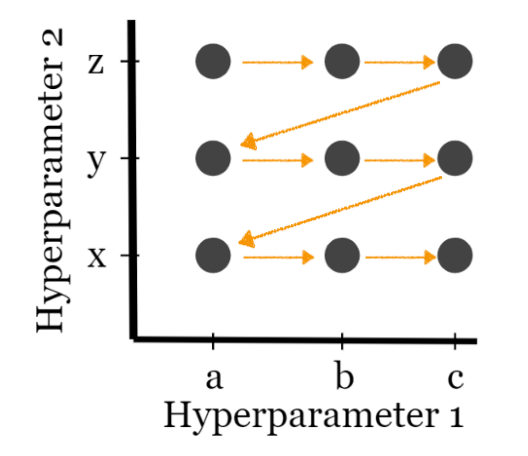

#### <center> Random Search </center> <img src='https://miro.medium.com/max/964/1*5SX-RFgQNUVO5z47eq2Vgg.png' width=300> 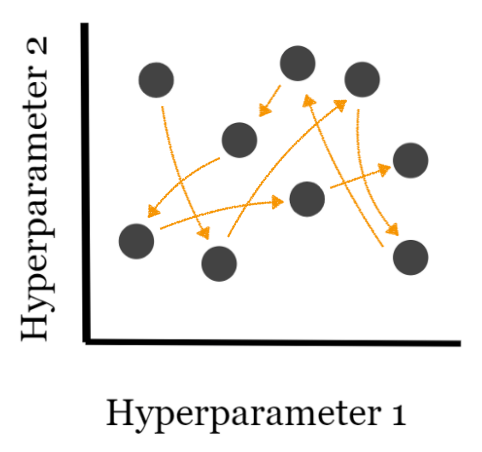
#### <center> Bayes Search </center>
<img src='https://miro.medium.com/max/944/1*g2E6yf3I4YwEVsK8JuEgNQ.png' width=300> 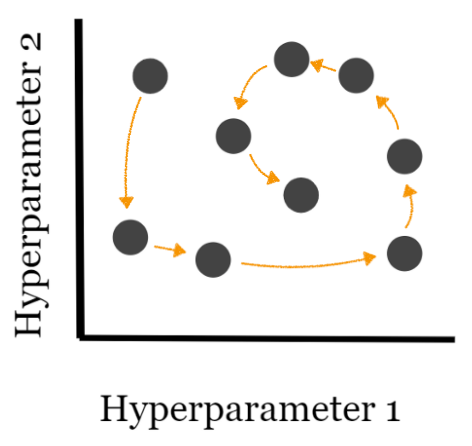

Рассмотрим более подробно одну из байесовских библиотек - [**optuna**](https://optuna.org/). В своей работе optuna использует байесовские алгоритмы подбора с возможностью удаления заведомо проигрышного пространства заданных гиперпараметров из анализа. Р

В отличие от классических sklearn методов, **optuna** может обрабатывать непрерывные значения гиперпараметров. Например, альфа или лямбда-регуляризации будут принимать любые значения с плавающей точкой в заданном диапазоне. Все это делает его одним из самых гибких инструментов настройки моделей, особенно часто применяется для обучения нейронных сетей.

In [288]:
!pip install optuna

Давайте обучим градиентный бустинг CatBoost и попробуем подобрать много разных гиперпараметров с помощью optuna.

In [296]:
import optuna

def train_model(trial):
    train_x, valid_x, train_y, valid_y = preprocess_data(df, test_size=0.1, lag_start=12, lag_end=48)

    params = {
        "objective": trial.suggest_categorical("loss_function", ["RMSE"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "num_trees": trial.suggest_int("num_tree", 1, 100),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)

    mse_errors = mean_squared_error(preds, valid_y)
    print(f'MSE: {mse_errors}')

    return mse_errors

In [298]:
study = optuna.create_study(direction="minimize")
study.optimize(train_model, n_trials=10, timeout=100)

print(f"Number of finished trials: {len(study.trials)}")

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-06-07 15:23:13,830] A new study created in memory with name: no-name-2869ceb1-06e8-472d-bf9c-de5aa6eb6f8e
[I 2025-06-07 15:23:14,233] Trial 0 finished with value: 2.660683465608456 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.0319313139090958, 'num_tree': 60, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7129452009479973}. Best is trial 0 with value: 2.660683465608456.
[I 2025-06-07 15:23:14,378] Trial 1 finished with value: 5.313795129820326 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.014555411412282365, 'num_tree': 98, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.066465194557017}. Best is trial 0 with value: 2.660683465608456.


MSE: 2.660683465608456
MSE: 5.313795129820326


[I 2025-06-07 15:23:18,856] Trial 2 finished with value: 6.345002114802513 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.016936990649966805, 'num_tree': 60, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.8290268100390925}. Best is trial 0 with value: 2.660683465608456.


MSE: 6.345002114802513


[I 2025-06-07 15:23:19,166] Trial 3 finished with value: 5.5398544177447775 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.013174072407860567, 'num_tree': 84, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35539984130265334}. Best is trial 0 with value: 2.660683465608456.


MSE: 5.5398544177447775


[I 2025-06-07 15:23:23,321] Trial 4 finished with value: 7.260971559587415 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04187191617732079, 'num_tree': 28, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.025389208728841}. Best is trial 0 with value: 2.660683465608456.


MSE: 7.260971559587415


[I 2025-06-07 15:23:24,435] Trial 5 finished with value: 8.707769357725784 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04056159850030522, 'num_tree': 19, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.107760194258926}. Best is trial 0 with value: 2.660683465608456.


MSE: 8.707769357725784


[I 2025-06-07 15:23:26,937] Trial 6 finished with value: 2.7058320469524677 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07506046565885745, 'num_tree': 31, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6122712506284833}. Best is trial 0 with value: 2.660683465608456.


MSE: 2.7058320469524677


[I 2025-06-07 15:23:34,823] Trial 7 finished with value: 10.69949572972141 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.012596025655649178, 'num_tree': 54, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.1718815843979336}. Best is trial 0 with value: 2.660683465608456.


MSE: 10.69949572972141


[I 2025-06-07 15:23:38,206] Trial 8 finished with value: 2.874796015209128 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.08230337048656555, 'num_tree': 24, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.15995534172481604}. Best is trial 0 with value: 2.660683465608456.
[I 2025-06-07 15:23:38,377] Trial 9 finished with value: 2.7649860504614514 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.03549734720163988, 'num_tree': 56, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5517237090648374}. Best is trial 0 with value: 2.660683465608456.


MSE: 2.874796015209128
MSE: 2.7649860504614514
Number of finished trials: 10
Best trial:
  Value: 2.660683465608456
  Params: 
    loss_function: RMSE
    learning_rate: 0.0319313139090958
    num_tree: 60
    depth: 7
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 1.7129452009479973


In [ ]:
import optuna

def train_model(trial):
    train_x, valid_x, train_y, valid_y = preprocess_data(df, test_size=0.1, lag_start=12, lag_end=48)

    params = {
        "objective": trial.suggest_categorical("loss_function", ["RMSE"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "num_trees": trial.suggest_int("num_tree", 1, 100),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)

    mse_errors = mean_squared_error(preds, valid_y)
    print(f'MSE: {mse_errors}')

    return mse_errors

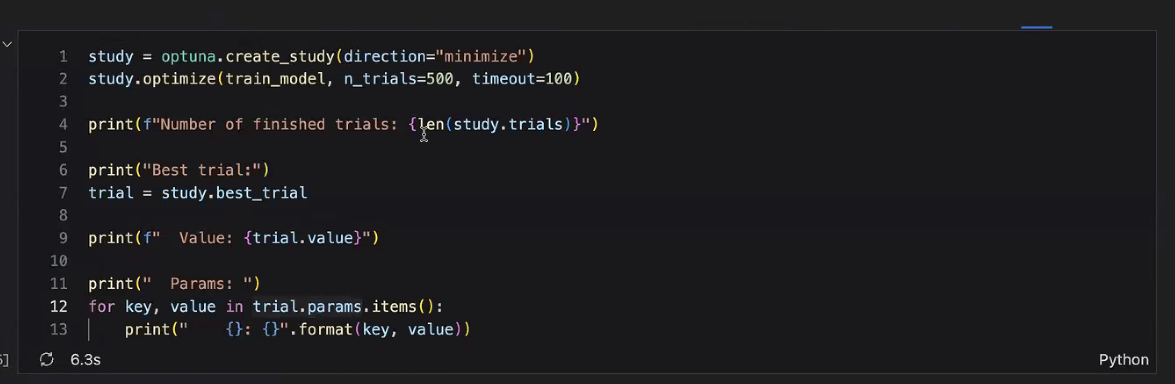

In [303]:
study = optuna.create_study(direction="minimize")
study. optimize(train_model, n_trials=500, timeout=100)
print(f"Number of finished trials: {len(study. trials)}")
print("Best trial: ")
trial = study. best_trial
print(f" Value: {trial.value]")
11 print(" Params: ")
12 for key, value in trial. params. items():
print("
(): (3"
format(key, value))


SyntaxError: f-string: unmatched ']' (14807851.py, line 6)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(train_model, n_trials=10, timeout=100)

print(f"Number of finished trials: {len(study.trials)}")

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

### Библиотеки для работы с временным рядами
    
К сожалению, это остается за рамками семинара, но хотим вам посоветовать популярные библиотеки для работы с временными рядами, на которые стоит обратить внимание, если вы будете работать с такими данными.

ETNA, Tsururu